In [338]:
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn import preprocessing
import boto3 as boto3
import pandas as pd

In [339]:


pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

df = pd.read_csv("C:/Users/lucab/Documents/FTT/EC/web_api_final.csv", sep=",", low_memory=False)
df = df[df.condition != 'not_specified']

In [340]:
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})

missing_value_df.sort_values('percent_missing', inplace=True)

apenasColunasComValores = missing_value_df[missing_value_df.percent_missing <= 75].column_name.tolist()

In [341]:
primeiroFiltroVariaveis = df[apenasColunasComValores].copy()

In [342]:
primeiroFiltroVariaveis = primeiroFiltroVariaveis.drop(
    columns=[
        'id',
        'Última versão compatível do sistema operacional',
        'link',
        'titulo',
        'Unnamed: 0',
        'prices.prices.last_updated',
        'prices.prices.type',
        'Modelo detalhado',
        'category_id',
        'address.state_id',
        'permalink',
        'address.city_name',
        'title_upper',
        'category_file',
        'address.city_id',
        'descricao',
        'Tipo de bateria',
        'Operadora',
        'É resistente a salpicos',
        'Com carregamento sem fio',
        'Taxa de atualização da tela',
        'Autonomia em standby',
        'Marca_x',
        'Modelo_x',
        'Peso_x',
        'Peso_y',
        'Linha_x',
        'Modelo do processador_x',
        'Com giroscópio',
        'É resistente ao pó',
        'Com sintonizador de TV',
        'Características principais das câmeras',
        'Última camada compatível de personalização do sistema operacional',
        'classificacao', #so tem um valor 
        'Com IMEI', #so tem um valor 
    ]
)


In [343]:
#Tratamento nome das colunas 
import re
variables = primeiroFiltroVariaveis.columns
# Colunarização da tabela

for n in variables:
    primeiroFiltroVariaveis = primeiroFiltroVariaveis.rename({
    n : re.sub('(\')|(\.)','_',re.sub('ó|ô','o',re.sub('é_','e_',re.sub('ã|â|á|à','a',re.sub(' ','_',n))))).lower()
    }, axis=1
    )

In [344]:
#Tratando as colunas valores das colunas 

listColumnsUpper = [
    'nome_do_sistema_operacional'
]

for a in listColumnsUpper:
    primeiroFiltroVariaveis[a] = primeiroFiltroVariaveis[a].str.upper()

In [345]:
condition = [
    primeiroFiltroVariaveis.nome_do_sistema_operacional.str.contains('.*ANDR.*', regex = True,na=False),
    primeiroFiltroVariaveis.nome_do_sistema_operacional.str.contains('.*IOS.*', regex = True,na=False)
]

value = [
    'ANDROID',
    'IOS'
]

primeiroFiltroVariaveis['sistema_operacional'] = np.select(condition, value, default='unknown')

In [346]:
# primeiroFiltroVariaveis['com_leitor_de_impressao_digital'].value_counts(dropna=False)


In [347]:
nemDropColumns = ['com_tela_tatil','com_sensor_de_proximidade','versao_original_do_sistema_operacional','com_ranhura_para_cartao_de_memoria','com_esim','com_reconhecimento_facial','com_mini_hdmi','tipo_de_resoluçao_da_tela','classificaçao_ip','com_barometro','com_sensor_de_frequência_cardíaca','camada_original_de_personalizaçao_do_sistema_operacional','tipo_de_tela','com_teclado_qwerty_físico','com_bateria_removível','com_radio','com_bússola','com_jack_3_5','capacidade_maxima_do_cartao_de_memoria','autonomia_de_conversaçao','resoluçao_da_tela','tecnologia_da_tela','altura_x_largura_x_profundidade','pixels_por_polegada','resoluçao_da_camera_traseira_principal','abertura_do_diafragma_da_camera_traseira','resoluçao_de_vídeo_da_camera_traseira','resoluçao_de_vídeo_da_camera_frontal','abertura_do_diafragma_da_camera_frontal','modelos_de_cpu','brilho_maximo_da_tela','resoluçao_das_cameras_traseiras','zoom_digital','mês_de_lançamento','proporçao_da_tela','resoluçao_da_camera_frontal_principal','modelo_de_gpu_x']
segundoFiltroVariaveis = primeiroFiltroVariaveis.drop(columns=nemDropColumns)

In [348]:
listBooleanVariables = ['é_dual_sim','com_camera','com_bluetooth','com_wi-fi','com_gps','com_acelerometro','com_conector_usb','com_flash_na_camara_frontal','é_resistente_a_agua','com_nfc','com_carregamento_rapido','com_leitor_de_impressao_digital','é_a_prova_d_agua','condition']


In [349]:
segundoFiltroVariaveis['é_dual_sim'].value_counts(dropna=False)

Sim    27925
Não    22500
NaN     1074
Name: é_dual_sim, dtype: int64

In [350]:
todas_variaveis = segundoFiltroVariaveis.columns

checkColumns = [x for x in todas_variaveis if x not in listBooleanVariables]

terceitoFiltroVariaveis = segundoFiltroVariaveis.copy()


In [351]:
for a in listBooleanVariables:
    if a == 'condition':
        terceitoFiltroVariaveis[a] = terceitoFiltroVariaveis[a].map(dict(used=1, new=0))
        terceitoFiltroVariaveis[a] = pd.to_numeric(terceitoFiltroVariaveis[a]).fillna(0)
    else:
        terceitoFiltroVariaveis[a] = terceitoFiltroVariaveis[a].map(dict(Sim=1, Não=0))
        terceitoFiltroVariaveis[a] = pd.to_numeric(terceitoFiltroVariaveis[a]).fillna(0)   
    
#     print(a, "\n ", terceitoFiltroVariaveis[a].value_counts(dropna=False), "\n")


In [352]:
terceitoFiltroVariaveis = terceitoFiltroVariaveis[terceitoFiltroVariaveis['memoria_interna'].str.contains("GB",na=False)]
terceitoFiltroVariaveis = terceitoFiltroVariaveis[terceitoFiltroVariaveis['memoria_ram'].str.contains("GB",na=False)]
terceitoFiltroVariaveis = terceitoFiltroVariaveis[terceitoFiltroVariaveis['velocidade_do_processador'].str.contains("GHz",na=False)]

terceitoFiltroVariaveis['memoria_interna'] = terceitoFiltroVariaveis['memoria_interna'].str.replace(' GB', "")
terceitoFiltroVariaveis['memoria_ram'] = terceitoFiltroVariaveis['memoria_ram'].str.replace(' GB', "")
terceitoFiltroVariaveis['tamanho_da_tela'] = terceitoFiltroVariaveis['tamanho_da_tela'].str.replace('(\")', "")
terceitoFiltroVariaveis['capacidade_da_bateria'] = terceitoFiltroVariaveis['capacidade_da_bateria'].str.replace('(mAh|Ah)', "")
terceitoFiltroVariaveis['velocidade_do_processador'] = terceitoFiltroVariaveis['velocidade_do_processador'].str.replace('(GHz)', "")
 
terceitoFiltroVariaveis['memoria_interna'] = pd.to_numeric(terceitoFiltroVariaveis['memoria_interna'])
terceitoFiltroVariaveis['memoria_ram'] = pd.to_numeric(terceitoFiltroVariaveis['memoria_ram'])
terceitoFiltroVariaveis['capacidade_da_bateria'] = pd.to_numeric(terceitoFiltroVariaveis['capacidade_da_bateria'])
terceitoFiltroVariaveis['velocidade_do_processador'] = pd.to_numeric(terceitoFiltroVariaveis['velocidade_do_processador'])


terceitoFiltroVariaveis = terceitoFiltroVariaveis[terceitoFiltroVariaveis.sistema_operacional != 'unknown']


C:\Users\lucab\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  import sys
C:\Users\lucab\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  
C:\Users\lucab\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  if __name__ == '__main__':


In [355]:
terceitoFiltroVariaveis = terceitoFiltroVariaveis.drop('nome_do_sistema_operacional',axis=1)

In [360]:
listaColunasLabelEncoder = [
    'address_state_name',
    'marca_y',
    'modelo_y',
    'modelo_upper',
    'modelo_do_processador_y',
    'linha_y',
    'modelo_de_gpu_y',
    'tamanhos_de_cartao_sim_compatíveis',
    'rede',
    'tipo_de_conector_de_carregamento',
    'tipos_de_cartao_de_memoria',
    'sistema_operacional'

]

checkColumns = [x for x in terceitoFiltroVariaveis.columns if x not in listaColunasLabelEncoder]

In [353]:
data_normalize = terceitoFiltroVariaveis.copy()

In [361]:
terceitoFiltroVariaveis[checkColumns]

,price,condition,é_dual_sim,memoria_interna,com_camera,com_bluetooth,tamanho_da_tela,com_wi-fi,com_gps,com_acelerometro,memoria_ram,com_conector_usb,quantidade_de_ranhuras_para_cartao_sim,capacidade_da_bateria,quantidade_de_núcleos_do_processador,com_leitor_de_impressao_digital,quantidade_de_cameras_traseiras,velocidade_do_processador,quantidade_de_cameras_frontais,ano_de_lançamento,com_flash_na_camara_frontal,é_a_prova_d_agua,é_resistente_a_agua,com_nfc,com_carregamento_rapido,memory
0,1989.00,0,1.0,128,1.0,1.0,6.4,1.0,1.0,1.0,6.0,1.0,2.0,6000.0,8.0,1.0,4.0,2.30,1.0,2020.0,0.0,0.0,0.0,0.0,1.0,128.0
1,1899.90,0,1.0,128,1.0,1.0,6.4,1.0,1.0,1.0,6.0,1.0,2.0,6000.0,8.0,1.0,4.0,2.30,1.0,2020.0,0.0,0.0,0.0,0.0,1.0,128.0
2,1999.00,0,1.0,128,1.0,1.0,6.4,1.0,1.0,1.0,6.0,1.0,2.0,6000.0,8.0,1.0,4.0,2.30,1.0,2020.0,0.0,0.0,0.0,0.0,1.0,128.0
3,1900.00,0,1.0,128,1.0,1.0,6.4,1.0,1.0,1.0,6.0,1.0,2.0,6000.0,8.0,1.0,4.0,2.30,1.0,2020.0,0.0,0.0,0.0,0.0,1.0,128.0
4,1699.00,0,1.0,128,1.0,1.0,6.4,1.0,1.0,1.0,6.0,1.0,2.0,6000.0,8.0,1.0,4.0,2.30,1.0,2020.0,0.0,0.0,0.0,0.0,1.0,128.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51537,1399.00,0,1.0,128,1.0,1.0,6,1.0,1.0,1.0,4.0,1.0,2.0,3300.0,8.0,1.0,3.0,2.20,NaN,NaN,0.0,0.0,0.0,0.0,0.0,128.0
51538,1249.00,0,1.0,32,1.0,1.0,6.22,1.0,1.0,1.0,3.0,1.0,2.0,5000.0,8.0,1.0,2.0,1.95,1.0,2019.0,0.0,0.0,0.0,0.0,1.0,32.0
51539,2849.99,0,1.0,128,1.0,1.0,6.47,1.0,1.0,1.0,6.0,1.0,2.0,5260.0,8.0,1.0,5.0,2.20,1.0,2019.0,0.0,0.0,0.0,1.0,1.0,128.0
51540,1399.00,0,1.0,64,1.0,1.0,6.4,1.0,1.0,1.0,4.0,1.0,2.0,5000.0,8.0,1.0,3.0,1.80,1.0,2019.0,0.0,0.0,0.0,0.0,0.0,64.0


In [329]:
labelEncoder = preprocessing.LabelEncoder()

# for column in ['address.state_name','Tamanho da tela','Tecnologia da tela','Capacidade da bateria','condition','Modelo_x','Linha_x','Marca_x']:
#     data_normalize[column]=labelEncoder.fit_transform(data_normalize[column])

for column in todas_variaveis:
    if column != 'price':    
        data_normalize[column]=labelEncoder.fit_transform(data_normalize[column])

In [330]:
# labelEncoder = preprocessing.OneHotEncoder()


# for column in checkColumns:
#     data_normalize[column]=labelEncoder.fit_transform(data_normalize[column])

In [331]:
c = data_normalize.corr()['price'].abs().sort_values(ascending = False)
c

price                                     1.000000
velocidade_do_processador                 0.017856
tamanho_da_tela                           0.017223
condition                                 0.016245
linha_y                                   0.015913
memoria_ram                               0.015802
memoria_interna                           0.014530
capacidade_da_bateria                     0.011378
modelo_upper                              0.011336
é_resistente_a_agua                       0.011005
é_dual_sim                                0.009926
tipo_de_conector_de_carregamento          0.007324
tipos_de_cartao_de_memoria                0.006996
peso_y                                    0.006845
quantidade_de_núcleos_do_processador      0.006538
quantidade_de_ranhuras_para_cartao_sim    0.006433
nome_do_sistema_operacional               0.006400
modelo_do_processador_y                   0.006392
sistema_operacional                       0.006386
com_nfc                        

In [332]:
data_normalize

,address_state_name,price,condition,modelo_upper,marca_y,modelo_y,é_dual_sim,nome_do_sistema_operacional,memoria_interna,com_camera,com_bluetooth,tamanho_da_tela,com_wi-fi,linha_y,com_gps,com_acelerometro,memoria_ram,com_conector_usb,tamanhos_de_cartao_sim_compatíveis,quantidade_de_ranhuras_para_cartao_sim,capacidade_da_bateria,quantidade_de_núcleos_do_processador,com_leitor_de_impressao_digital,peso_y,rede,quantidade_de_cameras_traseiras,velocidade_do_processador,quantidade_de_cameras_frontais,modelo_do_processador_y,ano_de_lançamento,com_flash_na_camara_frontal,tipo_de_conector_de_carregamento,é_a_prova_d_agua,é_resistente_a_agua,modelo_de_gpu_y,com_nfc,tipos_de_cartao_de_memoria,com_carregamento_rapido,memory,sistema_operacional
0,12,1989.00,0,691,7,698,1,0,26,1,1,121,1,74,1,1,15,1,5,2,153,5,1,147,4,3,25,0,57,11,0,3,0,0,56,0,1,1,21,0
1,13,1899.90,0,691,7,698,1,0,26,1,1,121,1,74,1,1,15,1,5,2,153,5,1,147,4,3,25,0,57,11,0,3,0,0,56,0,1,1,21,0
2,25,1999.00,0,691,7,698,1,0,26,1,1,121,1,74,1,1,15,1,5,2,153,5,1,147,4,3,25,0,57,11,0,3,0,0,56,0,1,1,21,0
3,25,1900.00,0,691,7,698,1,0,26,1,1,121,1,74,1,1,15,1,5,2,153,5,1,147,4,3,25,0,57,11,0,3,0,0,56,0,1,1,21,0
4,6,1699.00,0,691,7,698,1,0,26,1,1,121,1,74,1,1,15,1,5,2,153,5,1,147,4,3,25,0,57,11,0,3,0,0,56,0,1,1,21,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51537,19,1399.00,0,182,7,191,1,0,26,1,1,93,1,53,1,1,12,1,5,2,107,5,1,115,4,2,22,5,50,17,0,4,0,0,88,0,1,0,21,0
51538,25,1249.00,0,63,9,68,1,0,14,1,1,110,1,180,1,1,11,1,5,2,146,5,1,143,4,1,16,0,211,10,0,3,0,0,15,0,1,1,12,0
51539,25,2849.99,0,838,9,877,1,0,26,1,1,127,1,112,1,1,15,1,5,2,151,5,1,169,4,4,22,0,234,10,0,3,0,0,26,1,11,1,21,0
51540,25,1399.00,0,689,7,696,1,0,21,1,1,121,1,74,1,1,12,1,5,2,146,5,1,123,4,2,13,0,51,10,0,4,0,0,51,0,1,0,14,0


NameError: name 'sns' is not defined

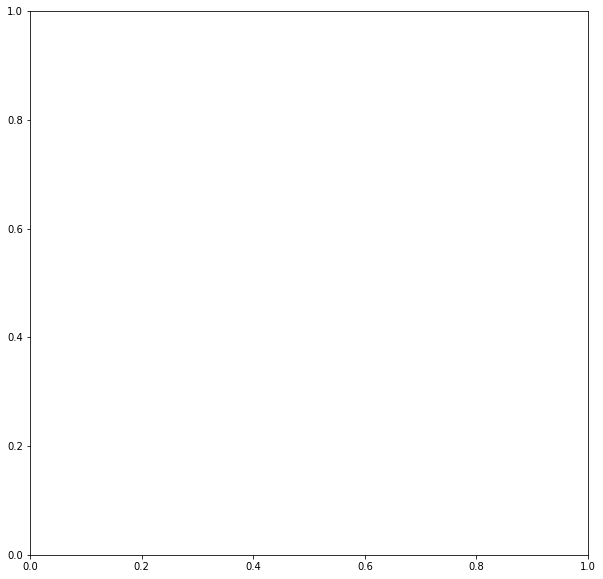

In [138]:
# correlation heatmap
corrmat = data_normalize.drop('price',axis=1).corr().abs() 
plt.subplots(figsize=(10,10))
sns.heatmap(corrmat, annot = True)